
#**TP : CNN pour Classification d'Images**
**Nom de l'étudiant : Claudia Florez**


Ce modèle est un classifieur CNN qui peut être utilisé pour la classification
d'images et sauvegardé pour une application Flutter.

Objectifs du TP:
1. Comprendre l'architecture CNN
2. Entraîner un modèle sur vos données
3. Sauvegarder le modèle pour Flutter (TFLite)
4. Utiliser le GPU de Google Colab



In [1]:
#===========================================================================
# SECTION 1: CONFIGURATION ET VÉRIFICATION DU GPU
#===========================================================================

import tensorflow as tf
print("Version de TensorFlow:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

# Configurer l'utilisation de la mémoire GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) configuré(s) avec memory growth.")
    except RuntimeError as e:
        print(e)
else:
    print("Aucun GPU détecté. Utilisation du CPU.")

Version de TensorFlow: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 GPU(s) configuré(s) avec memory growth.


In [2]:
#===========================================================================
# SECTION 2: IMPORTATION DES LIBRAIRIES ET SETUP DU PROJET
#===========================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from datetime import datetime

# Keras/TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D, Activation
)
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
)
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB3

import os
from pathlib import Path

print("Suppression d'une ancienne version du repo (si existe)...")
!rm -rf /content/Project_cnn_flutter

print("Clonage du dépôt GitHub...")
!git clone https://github.com/ClaFlorez/Project_cnn_flutter.git /content/Project_cnn_flutter

# ---------- RUTAS DEL DATASET ----------
BASE_DIR = "/content/Project_cnn_flutter"

DATA_PATHS = {
    "train":      f"{BASE_DIR}/donnees/entrainement",
    "validation": f"{BASE_DIR}/donnees/validation",
    "test":       f"{BASE_DIR}/donnees/test",
}

print("\nVérification des dossiers du dataset:")
for split, path in DATA_PATHS.items():
    p = Path(path)
    print(f"- {split}: {p}  → existe: {p.exists()}")
    if p.exists():
        print("  Contenu:", os.listdir(p))

# ---------- DETECTAR CLASES DESDE train ----------
train_dir = Path(DATA_PATHS["train"])
if train_dir.exists():
    class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
    print("\nClasses détectées dans 'entrainement':")
    for i, name in enumerate(class_names):
        print(f"  {i}: {name}")
else:
    class_names = []
    print("\nAttention: dossier d'entraînement introuvable.")

# ---------- COMPROBAR GPU ----------
print("\nVérification de la GPU dans cet environnement:")
gpus = tf.config.list_physical_devices("GPU")
print("GPU disponibles:", gpus)
if gpus:
    print("TensorFlow voit la GPU, entraînement accéléré possible.")
else:
    print("Pas de GPU détectée. Vérifier Runtime → Change runtime type → GPU.")

print("\nSETUP TERMINÉ. Utilisez ces chemins dans votre code Python.")


Suppression d'une ancienne version du repo (si existe)...
Clonage du dépôt GitHub...
Cloning into '/content/Project_cnn_flutter'...
remote: Enumerating objects: 30088, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 30088 (delta 4), reused 0 (delta 0), pack-reused 30076 (from 3)
Receiving objects: 100% (30088/30088), 304.64 MiB | 60.22 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (30006/30006), done.

Vérification des dossiers du dataset:
- train: /content/Project_cnn_flutter/donnees/entrainement  → existe: True
  Contenu: ['elephant', 'zebre', 'tigre', 'rhino', 'leopard', 'girafe']
- validation: /content/Project_cnn_flutter/donnees/validation  → existe: True
  Contenu: ['elephant', 'zebre', 'tigre', 'rhino', 'leopard', 'girafe']
- test: /content/Project_cnn_flutter/donnees/test  → existe: True
  Contenu: ['elephant', 'zebre', 'tigre', 'rhino', 'leopard', 'girafe']

Classes détectées dans 'ent

In [3]:
#===========================================================================
# SECTION 3: PARAMÈTRES DU MODÈLE ET CHEMINS
#===========================================================================

PARAMS = {
    'img_width': 224,        # Taille requise pour MobileNetV2
    'img_height': 224,
    'img_channels': 3,       # Images couleur
    'num_classes': 6,        # Elephant, girafe, leopard, rhino, tigre, zebre
    'batch_size': 32,

    'epochs_phase1': 15,     # Entraînement de la tête du réseau
    'epochs_phase2': 35,     # Fine-tuning de MobileNetV2

    'learning_rate': 0.001,  # Phase 1
    'fine_tune_lr': 0.0001   # Phase 2
}

# Monter Drive pour sauvegarder les modèles
from google.colab import drive
drive.mount('/content/drive')

SAVE_PATH = '/content/drive/MyDrive/models/'
os.makedirs(SAVE_PATH, exist_ok=True)

# Nom cohérent du modèle
model_name = "cnn_model_animals_2025"

# Chemins centralisés (format .keras pour éviter le warning HDF5)
PATHS = {
    "model":       os.path.join(SAVE_PATH, f"{model_name}_full_model.keras"),
    "best_model":  os.path.join(SAVE_PATH, f"{model_name}_best.keras"),
    "tflite":      os.path.join(SAVE_PATH, f"{model_name}.tflite"),
    "labels":      os.path.join(SAVE_PATH, f"{model_name}_labels.txt"),
    "history_png": os.path.join(SAVE_PATH, f"{model_name}_training_history.png"),
    "cm_png":      os.path.join(SAVE_PATH, f"{model_name}_confusion_matrix.png"),
    "flutter_txt": os.path.join(SAVE_PATH, f"{model_name}_flutter_instructions.txt"),
    "summary_txt": os.path.join(SAVE_PATH, f"{model_name}_summary.txt"),
}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#===========================================================================
# SECTION 4: CHARGEMENT ET PRÉPARATION DES DONNÉES (EfficientNetB3)
#===========================================================================

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Générateur pour l'entraînement (avec augmentation + preprocess_input)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.15,
    shear_range=0.10,
    horizontal_flip=True,
    brightness_range=[0.85, 1.15],
    fill_mode='nearest'
)

# Générateurs pour validation et test (seulement preprocess_input, sans augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    DATA_PATHS['train'],
    target_size=(PARAMS['img_height'], PARAMS['img_width']),
    batch_size=PARAMS['batch_size'],
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    DATA_PATHS['validation'],
    target_size=(PARAMS['img_height'], PARAMS['img_width']),
    batch_size=PARAMS['batch_size'],
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    DATA_PATHS['test'],
    target_size=(PARAMS['img_height'], PARAMS['img_width']),
    batch_size=PARAMS['batch_size'],
    class_mode='categorical',
    shuffle=False
)

print(f"Classes détectées: {train_generator.class_indices}")
print(f"Nombre d'images - Train: {train_generator.samples}, "
      f"Val: {validation_generator.samples}, "
      f"Test: {test_generator.samples}")

# --- Vérification du preprocess_input ---
batch, labels = next(train_generator)
print("Batch shape:", batch.shape)
print("Min:", batch.min(), "Max:", batch.max(), "Mean:", batch.mean())


Found 20400 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.
Found 6000 images belonging to 6 classes.
Classes détectées: {'elephant': 0, 'girafe': 1, 'leopard': 2, 'rhino': 3, 'tigre': 4, 'zebre': 5}
Nombre d'images - Train: 20400, Val: 3600, Test: 6000
Batch shape: (32, 224, 224, 3)
Min: 0.0 Max: 255.0 Mean: 133.18753


In [5]:
#===========================================================================
# SECTION 4B: CLASS WEIGHTS POUR BOOSTER CERTAINES CLASSES
#===========================================================================

print("Classes détectées par train_generator:", train_generator.class_indices)

y_train_indices = train_generator.classes

base_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)

class_weights = {i: w for i, w in enumerate(base_class_weights)}

print("\nClass weights de base (avant boost) :")
for cls_name, idx in train_generator.class_indices.items():
    print(f"  Classe {cls_name:8s} (idx {idx}) -> weight = {class_weights[idx]:.3f}")

boost_factor = 2.0
boost_classes = ['elephant', 'rhino', 'tigre']

for cls in boost_classes:
    if cls in train_generator.class_indices:
        idx = train_generator.class_indices[cls]
        class_weights[idx] *= boost_factor

print("\nClass weights après boost (elephant, rhino, tigre) :")
for cls_name, idx in train_generator.class_indices.items():
    print(f"  Classe {cls_name:8s} (idx {idx}) -> weight = {class_weights[idx]:.3f}")


Classes détectées par train_generator: {'elephant': 0, 'girafe': 1, 'leopard': 2, 'rhino': 3, 'tigre': 4, 'zebre': 5}

Class weights de base (avant boost) :
  Classe elephant (idx 0) -> weight = 1.000
  Classe girafe   (idx 1) -> weight = 1.000
  Classe leopard  (idx 2) -> weight = 1.000
  Classe rhino    (idx 3) -> weight = 1.000
  Classe tigre    (idx 4) -> weight = 1.000
  Classe zebre    (idx 5) -> weight = 1.000

Class weights après boost (elephant, rhino, tigre) :
  Classe elephant (idx 0) -> weight = 2.000
  Classe girafe   (idx 1) -> weight = 1.000
  Classe leopard  (idx 2) -> weight = 1.000
  Classe rhino    (idx 3) -> weight = 2.000
  Classe tigre    (idx 4) -> weight = 2.000
  Classe zebre    (idx 5) -> weight = 1.000


In [6]:
#===========================================================================
# SECTION 5: CONSTRUCTION DU MODÈLE CNN (EfficientNetB3 - entrées [0,1])
#===========================================================================

def create_efficientnet_model(input_shape, num_classes):
    """
    Modèle de classification basé sur EfficientNetB3.
    Les images en entrée sont supposées déjà normalisées en [0, 1].
    """

    # Entrée
    inputs = Input(shape=input_shape, name="input_image")

    # Backbone EfficientNetB3 pré-entraîné sur ImageNet
    # IMPORTANT : on NE donne PAS de name ici → Keras va utiliser "efficientnetb3"
    base_model = EfficientNetB3(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs,
        pooling=None
    )

    # Maintenant que les poids sont chargés, on peut renommer pour le fine-tuning
    base_model._name = "base_model"   # pour que model.get_layer("base_model") fonctionne

    # Phase 1 : gel de tout le backbone
    base_model.trainable = False

    # Tête de classification
    x = base_model.output
    x = GlobalAveragePooling2D(name="global_avg_pool")(x)
    x = Dropout(0.3, name="dropout_features")(x)

    x = Dense(256, name="dense_256")(x)
    x = BatchNormalization(name="bn_dense")(x)
    x = Activation("relu", name="relu_dense")(x)
    x = Dropout(0.5, name="dropout_dense")(x)

    outputs = Dense(num_classes, activation="softmax", name="predictions")(x)

    model = Model(inputs=inputs, outputs=outputs, name="animals_efficientnetb3")

    return model


In [7]:
#===========================================================================
# SECTION 5B CREATION DU MODÈLE (EfficientNetB3)
#===========================================================================

input_shape = (
    PARAMS['img_height'],
    PARAMS['img_width'],
    PARAMS['img_channels']
)

model = create_efficientnet_model(input_shape, PARAMS['num_classes'])
model.summary()

Model: "animals_efficientnetb3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_image[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,179,573 (42.65 MB)

 Trainable params: 395,526 (1.51 MB)

 Non-trainable params: 10,784,047 (41.14 MB)

In [8]:
#===========================================================================
# SECTION 6: COMPILATION DU MODÈLE (PHASE 1)
#===========================================================================

print("\n" + "="*60)
print("COMPILATION DU MODÈLE (PHASE 1 - tête seulement)")
print("="*60 + "\n")

base_lr = PARAMS.get('learning_rate', 1e-3)
optimizer = Adam(learning_rate=base_lr)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]
)

print("Modèle compilé avec :")
print(f"  - learning rate = {base_lr}")
print(f"  - loss          = categorical_crossentropy")
print(f"  - metrics       = accuracy, precision, recall")



COMPILATION DU MODÈLE (PHASE 1 - tête seulement)

Modèle compilé avec :
  - learning rate = 0.001
  - loss          = categorical_crossentropy
  - metrics       = accuracy, precision, recall


In [9]:
#===========================================================================
# SECTION 7: CALLBACKS POUR PHASE 1 ET PHASE 2 (VERSION UNIFIÉE)
#===========================================================================

import datetime as dt_mod

log_dir_phase1 = os.path.join(SAVE_PATH, "logs", model_name + "_phase1")
log_dir_phase2 = os.path.join(SAVE_PATH, "logs", model_name + "_phase2")

early_stopping_phase1 = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

early_stopping_phase2 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint_phase1 = ModelCheckpoint(
    filepath=PATHS["best_model"],
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

checkpoint_phase2 = ModelCheckpoint(
    filepath=PATHS["best_model"],
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
)

reduce_lr_phase1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

reduce_lr_phase2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

tensorboard_phase1 = TensorBoard(
    log_dir=log_dir_phase1,
    histogram_freq=1
)

tensorboard_phase2 = TensorBoard(
    log_dir=log_dir_phase2,
    histogram_freq=1
)

callbacks_phase1 = [
    early_stopping_phase1,
    reduce_lr_phase1,
    checkpoint_phase1,
    tensorboard_phase1
]

callbacks_phase2 = [
    early_stopping_phase2,
    reduce_lr_phase2,
    checkpoint_phase2,
    tensorboard_phase2
]

print("Callbacks configurés pour PHASE 1 et PHASE 2.")


Callbacks configurés pour PHASE 1 et PHASE 2.


In [10]:
#===========================================================================
# SECTION 8: ENTRAÎNEMENT DU MODÈLE - PHASE 1 (TÊTE SEULEMENT)
#===========================================================================

print("\n" + "="*60)
print("DÉBUT DE L'ENTRAÎNEMENT - PHASE 1 (tête seulement)")
print("="*60 + "\n")

phase1_start = datetime.now()
print("Phase 1 - début :", phase1_start.strftime("%Y-%m-%d %H:%M:%S"))

epochs_phase1 = PARAMS['epochs_phase1']

history_phase1 = model.fit(
    train_generator,
    epochs=epochs_phase1,
    validation_data=validation_generator,
    callbacks=callbacks_phase1,
    verbose=1
)

phase1_end = datetime.now()
print("Phase 1 - fin   :", phase1_end.strftime("%Y-%m-%d %H:%M:%S"))
print("Durée de la PHASE 1 :", str(phase1_end - phase1_start))



DÉBUT DE L'ENTRAÎNEMENT - PHASE 1 (tête seulement)

Phase 1 - début : 2025-12-10 01:46:19


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9126 - loss: 0.2605 - precision: 0.9379 - recall: 0.8935
Epoch 1: val_accuracy improved from -inf to 0.98250, saving model to /content/drive/MyDrive/models/cnn_model_animals_2025_best.keras
638/638 ━━━━━━━━━━━━━━━━━━━━ 370s 487ms/step - accuracy: 0.9126 - loss: 0.2603 - precision: 0.9379 - recall: 0.8936 - val_accuracy: 0.9825 - val_loss: 0.0501 - val_precision: 0.9849 - val_recall: 0.9794 - learning_rate: 0.0010
Epoch 2/15
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9632 - loss: 0.1154 - precision: 0.9712 - recall: 0.9576
Epoch 2: val_accuracy improved from 0.98250 to 0.98500, saving model to /content/drive/MyDrive/models/cnn_model_animals_2025_best.keras
638/638 ━━━━━━━━━━━━━━━━━━━━ 249s 390ms/step - accuracy: 0.9632 - loss: 0.1154 - precision: 0.9712 - recall: 0.9576 - val_accuracy: 0.9850 - val_loss: 0.0423 - val_precision: 0.9866 - val_recall: 0.9836 - learning_rate: 0.0010
Epoch 3/15
638/638 ━━━━━━━━

In [12]:
#===========================================================================
# SECTION 9: FINE-TUNING D'EfficientNetB3 (PHASE 2 SANS base_model)
#===========================================================================

print("\n" + "="*60)
print("DÉBUT DU FINE-TUNING - PHASE 2 (EfficientNetB3)")
print("="*60 + "\n")

phase2_start = datetime.now()
print("Phase 2 - début :", phase2_start.strftime("%Y-%m-%d %H:%M:%S"))

# 1) Identifier la limite entre le backbone EfficientNetB3 et la tête
#    On considère que tout ce qui est avant 'global_avg_pool' est le backbone.
backbone_end_idx = None
for i, layer in enumerate(model.layers):
    if layer.name == "global_avg_pool":
        backbone_end_idx = i
        break

if backbone_end_idx is None:
    raise ValueError("Impossible de trouver la couche 'global_avg_pool' dans le modèle.")

print(f"Index de 'global_avg_pool' (début de la tête) : {backbone_end_idx}")

backbone_layers = model.layers[:backbone_end_idx]
num_backbone_layers = len(backbone_layers)
print("Nombre de couches dans le backbone :", num_backbone_layers)

# 2) Stratégie de fine-tuning :
#    - Geler les ~20% premières couches (features très basiques)
#    - Déverrouiller les 80% restantes du backbone
fine_tune_at = int(num_backbone_layers * 0.20)

for i, layer in enumerate(backbone_layers):
    if i < fine_tune_at:
        layer.trainable = False
    else:
        layer.trainable = True

# La tête (global_avg_pool, dense_256, etc.) reste toujours entraînable
for layer in model.layers[backbone_end_idx:]:
    layer.trainable = True

print(f"Couches du backbone gelées jusqu'à l'index {fine_tune_at} (sur {num_backbone_layers}).")

# 3) Re-compiler le modèle avec un plus petit learning rate pour le fine-tuning
fine_tune_lr = PARAMS.get('fine_tune_lr', 5e-5)
print(f"Learning rate pour le fine-tuning : {fine_tune_lr}")

model.compile(
    optimizer=Adam(learning_rate=fine_tune_lr),
    loss="categorical_crossentropy",
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
)

# 4) Lancer la PHASE 2 en continuant après la phase 1
epochs_phase1 = PARAMS['epochs_phase1']
epochs_phase2 = PARAMS.get('epochs_phase2', 20)

history_phase2 = model.fit(
    train_generator,
    epochs=epochs_phase1 + epochs_phase2,
    initial_epoch=epochs_phase1,
    validation_data=validation_generator,
    callbacks=callbacks_phase2,
    class_weight=class_weights,
    verbose=1
)

phase2_end = datetime.now()
print("Phase 2 - fin   :", phase2_end.strftime("%Y-%m-%d %H:%M:%S"))
print("Durée de la PHASE 2 :", str(phase2_end - phase2_start))

print("\n" + "="*60)
print("ENTRAÎNEMENT TERMINÉ (PHASE 1 + PHASE 2 - EfficientNetB3)")
print("="*60 + "\n")



DÉBUT DU FINE-TUNING - PHASE 2 (EfficientNetB3)

Phase 2 - début : 2025-12-10 02:58:08
Index de 'global_avg_pool' (début de la tête) : 385
Nombre de couches dans le backbone : 385
Couches du backbone gelées jusqu'à l'index 77 (sur 385).
Learning rate pour le fine-tuning : 0.0001
Epoch 16/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9285 - loss: 0.3296 - precision: 0.9385 - recall: 0.9207
Epoch 16: val_accuracy improved from -inf to 0.98750, saving model to /content/drive/MyDrive/models/cnn_model_animals_2025_best.keras
638/638 ━━━━━━━━━━━━━━━━━━━━ 449s 521ms/step - accuracy: 0.9286 - loss: 0.3295 - precision: 0.9386 - recall: 0.9208 - val_accuracy: 0.9875 - val_loss: 0.0351 - val_precision: 0.9894 - val_recall: 0.9867 - learning_rate: 1.0000e-04
Epoch 17/50
638/638 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9802 - loss: 0.0982 - precision: 0.9827 - recall: 0.9770
Epoch 17: val_accuracy improved from 0.98750 to 0.99056, saving model to /content/drive/MyDrive/models

In [13]:
print("\n" + "="*60)
print("ÉVALUATION FINALE SUR LE JEU DE TEST")
print("="*60 + "\n")

test_loss, test_acc, test_prec, test_rec = model.evaluate(test_generator, verbose=1)

print(f"Test Loss      : {test_loss:.4f}")
print(f"Test Accuracy  : {test_acc:.4%}")
print(f"Test Precision : {test_prec:.4%}")
print(f"Test Recall    : {test_rec:.4%}")


ÉVALUATION FINALE SUR LE JEU DE TEST

188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9874 - loss: 0.0558 - precision: 0.9881 - recall: 0.9859
Test Loss      : 0.0398
Test Accuracy  : 99.0833%
Test Precision : 99.1487%
Test Recall    : 99.0000%


188/188 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step
Classes: ['elephant', 'girafe', 'leopard', 'rhino', 'tigre', 'zebre']


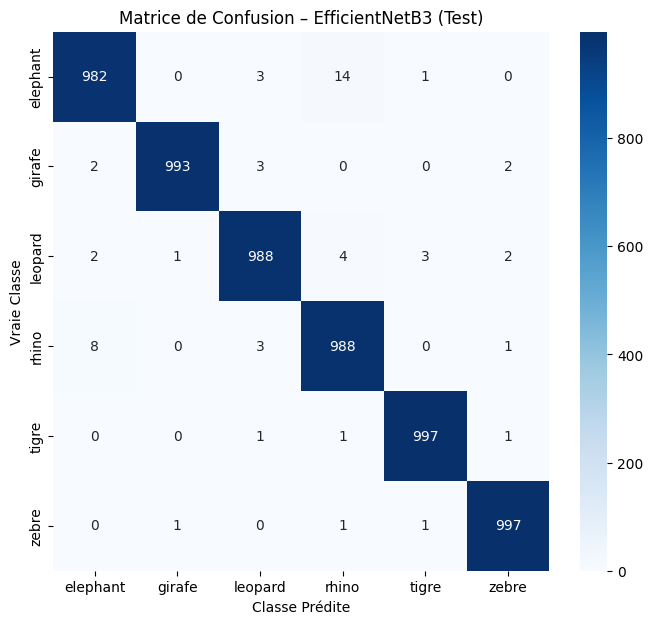

In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prédictions sur le jeu de test
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob, axis=1)

# Vraies étiquettes
y_true = test_generator.classes

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

class_names = list(test_generator.class_indices.keys())
print("Classes:", class_names)

plt.figure(figsize=(8, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Classe Prédite")
plt.ylabel("Vraie Classe")
plt.title("Matrice de Confusion – EfficientNetB3 (Test)")
plt.show()


Clés disponibles: dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])


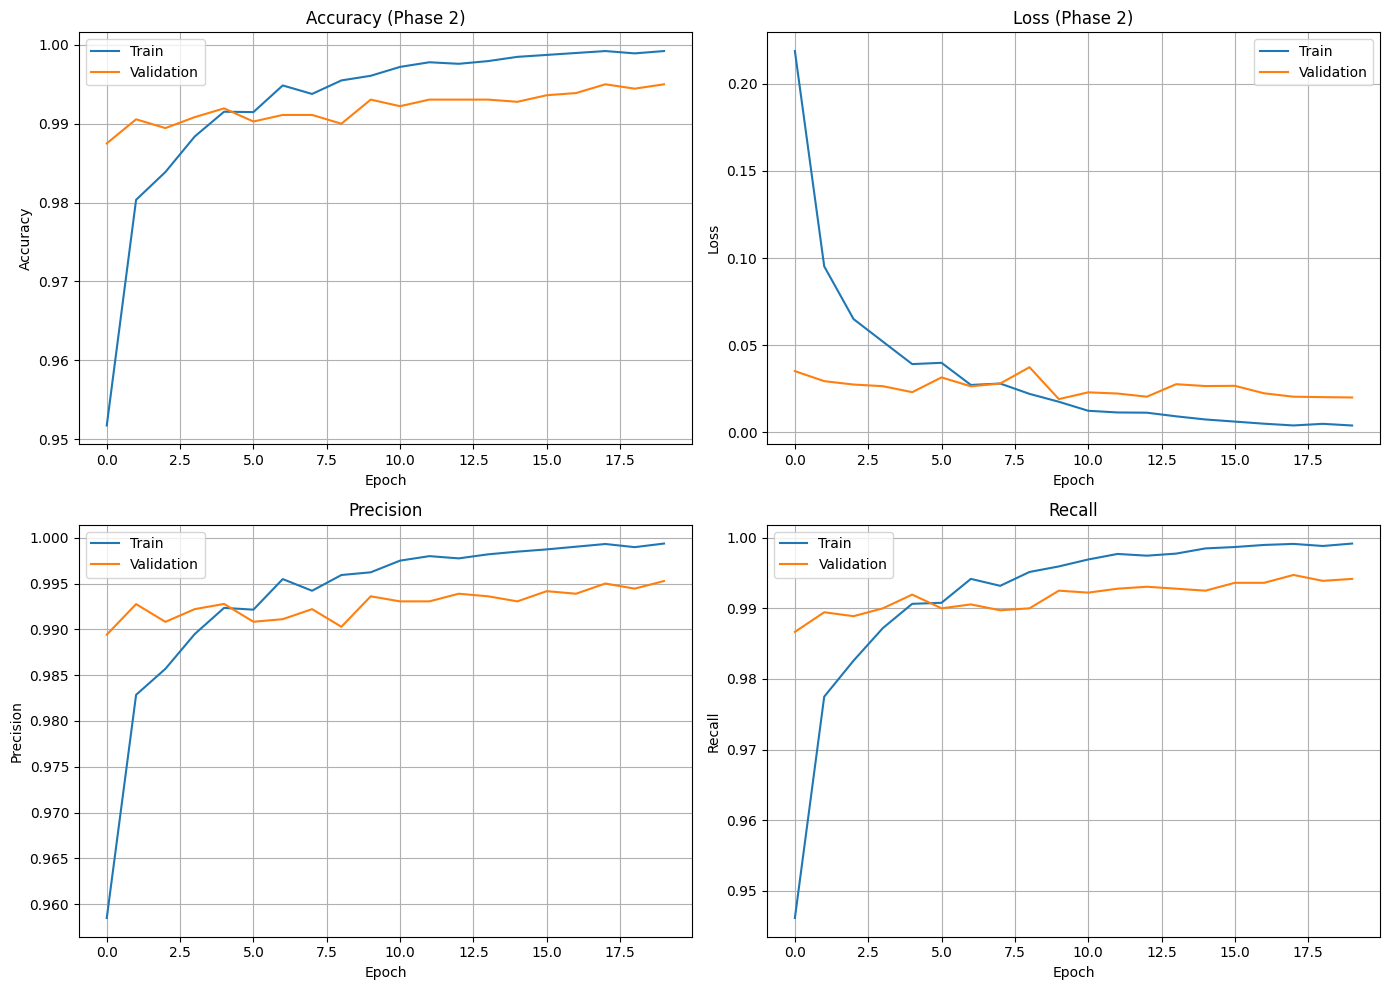

In [15]:
#===========================================================================
# SECTION 9B: VISUALISATION DES RÉSULTATS
#===========================================================================

def plot_basic_history(history):
    plt.figure(figsize=(12, 5))

    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()
    else:
        print("accuracy / val_accuracy non disponibles dans history.history.keys()")

    if 'loss' in history.history and 'val_loss' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()
    else:
        print("loss / val_loss non disponibles")

    plt.tight_layout()
    plt.show()

def plot_full_history(history, title_suffix=""):
    keys = history.history.keys()
    print("Clés disponibles:", keys)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    axes[0, 0].plot(history.history.get('accuracy', []), label='Train')
    axes[0, 0].plot(history.history.get('val_accuracy', []), label='Validation')
    axes[0, 0].set_title('Accuracy' + title_suffix)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].grid(True)
    axes[0, 0].legend()

    axes[0, 1].plot(history.history.get('loss', []), label='Train')
    axes[0, 1].plot(history.history.get('val_loss', []), label='Validation')
    axes[0, 1].set_title('Loss' + title_suffix)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True)
    axes[0, 1].legend()

    if 'precision' in keys:
        axes[1, 0].plot(history.history['precision'], label='Train')
        axes[1, 0].plot(history.history.get('val_precision', []), label='Validation')
        axes[1, 0].set_title('Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].grid(True)
        axes[1, 0].legend()
    else:
        axes[1, 0].text(0.5, 0.5, "Precision non disponible", ha='center')
        axes[1, 0].set_axis_off()

    if 'recall' in keys:
        axes[1, 1].plot(history.history['recall'], label='Train')
        axes[1, 1].plot(history.history.get('val_recall', []), label='Validation')
        axes[1, 1].set_title('Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].grid(True)
        axes[1, 1].legend()
    else:
        axes[1, 1].text(0.5, 0.5, "Recall non disponible", ha='center')
        axes[1, 1].set_axis_off()

    plt.tight_layout()
    plt.show()

plot_full_history(history_phase2, title_suffix=" (Phase 2)")

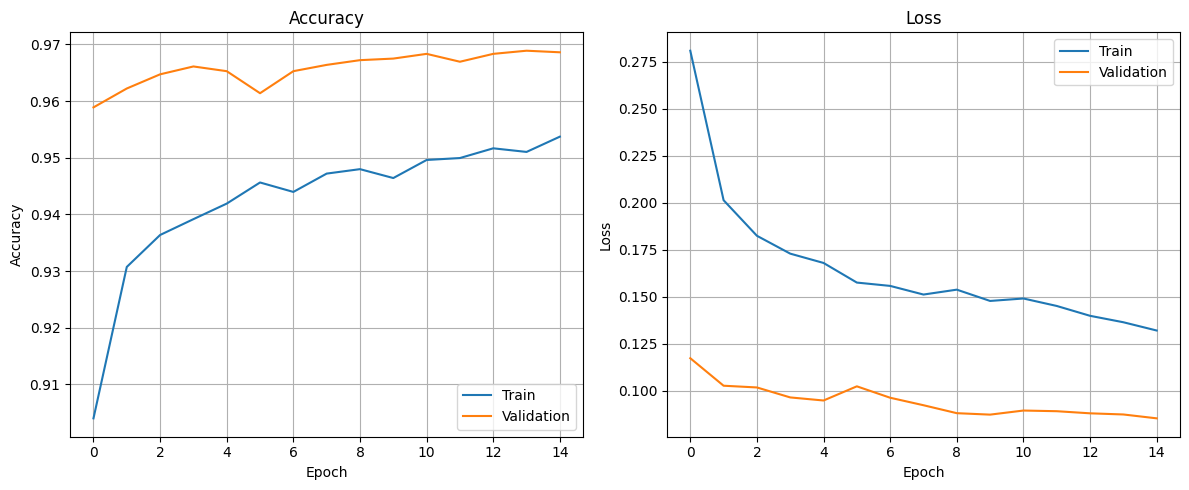

In [34]:
plot_basic_history(history_phase1)


ÉVALUATION SUR L'ENSEMBLE DE TEST

188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9874 - loss: 0.0558 - precision: 0.9881 - recall: 0.9859
Noms des métriques dans le modèle : ['loss', 'compile_metrics']

Résultats Keras sur le test:
  - Accuracy: 0.9908
  - Loss:     0.0398
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step
Classes : ['elephant', 'girafe', 'leopard', 'rhino', 'tigre', 'zebre']

Métriques globales (macro) sur le test:
  - Precision: 0.9908
  - Recall:    0.9908
  - F1-Score:  0.9908

RAPPORT DE CLASSIFICATION (par classe)
              precision    recall  f1-score   support

    elephant       0.99      0.98      0.98      1000
      girafe       1.00      0.99      1.00      1000
     leopard       0.99      0.99      0.99      1000
       rhino       0.98      0.99      0.98      1000
       tigre       1.00      1.00      1.00      1000
       zebre       0.99      1.00      1.00      1000

    accuracy                           0.99      6000
   macro avg       0.

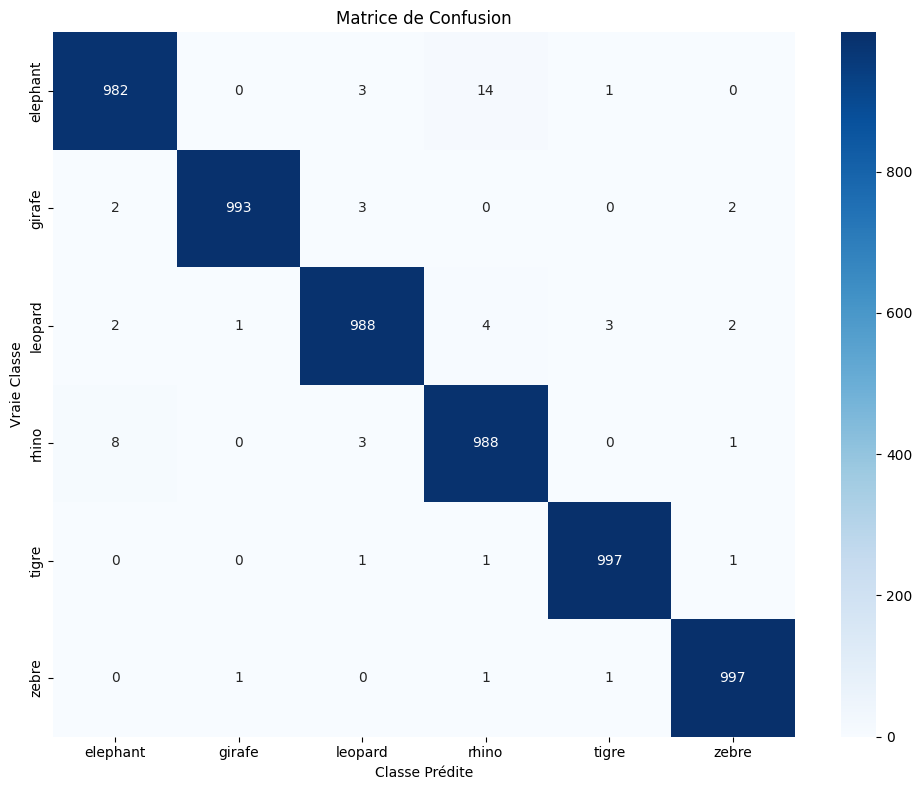

In [16]:
#===========================================================================
# SECTION 10: ÉVALUATION SUR L'ENSEMBLE DE TEST
#===========================================================================

import seaborn as sns # Import the seaborn library

print("\n" + "="*60)
print("ÉVALUATION SUR L'ENSEMBLE DE TEST")
print("="*60 + "\n")

results = model.evaluate(test_generator, verbose=1)
metric_names = model.metrics_names
metrics_dict = dict(zip(metric_names, results))

print("Noms des métriques dans le modèle :", metric_names)

test_loss = results[0]
test_acc = results[1]

print(f"\nRésultats Keras sur le test:")
print(f"  - Accuracy: {test_acc:.4f}")
print(f"  - Loss:     {test_loss:.4f}")

test_generator.reset()
y_prob = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())
print("Classes :", class_names)

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

test_precision = precision_score(y_true, y_pred_classes, average='macro')
test_recall    = recall_score(y_true, y_pred_classes, average='macro')
test_f1        = f1_score(y_true, y_pred_classes, average='macro')

print(f"\nMétriques globales (macro) sur le test:")
print(f"  - Precision: {test_precision:.4f}")
print(f"  - Recall:    {test_recall:.4f}")
print(f"  - F1-Score:  {test_f1:.4f}")

print("\n" + "="*60)
print("RAPPORT DE CLASSIFICATION (par classe)")
print("="*60)
print(classification_report(y_true, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Matrice de Confusion')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.tight_layout()
plt.savefig(PATHS["cm_png"], dpi=300)
plt.show()


In [17]:
#===========================================================================
# SECTION 11: CONVERSION ET SAUVEGARDE TFLITE
#===========================================================================

print("\n" + "="*60)
print("CONVERSION ET SAUVEGARDE POUR FLUTTER (TFLite)")
print("="*60 + "\n")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

tflite_path = PATHS["tflite"]
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

tflite_path_fixed = os.path.join(SAVE_PATH, "cnn_model_animals.tflite")
with open(tflite_path_fixed, 'wb') as f:
    f.write(tflite_model)

print("Modèle TFLite principal :", tflite_path)
print("Modèle TFLite fixe pour Flutter :", tflite_path_fixed)
print(f"Taille du modèle TFLite: {len(tflite_model) / 1024:.2f} KB")



CONVERSION ET SAUVEGARDE POUR FLUTTER (TFLite)

Saved artifact at '/tmp/tmpbaxhgy_x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_image')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136842491307664: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136842491309392: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136844711959952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136844711957072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136844711958992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136844711960528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136844711958032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136844711961296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136844711963024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136844711963216: T

In [18]:
#===========================================================================
# SECTION 12: TEST DU MODÈLE TFLITE
#===========================================================================

print("\n" + "="*60)
print("VÉRIFICATION DU MODÈLE TFLITE")
print("="*60 + "\n")

interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Fichier TFLite utilisé:", tflite_path)

print("Détails d'entrée:")
print(f"  - Shape: {input_details[0]['shape']}")
print(f"  - Type: {input_details[0]['dtype']}")

print("\nDétails de sortie:")
print(f"  - Shape: {output_details[0]['shape']}")
print(f"  - Type: {output_details[0]['dtype']}")

test_generator.reset()
test_image, test_label = next(test_generator)
test_image_single = test_image[0:1]

interpreter.set_tensor(input_details[0]['index'], test_image_single.astype(np.float32))
interpreter.invoke()
tflite_prediction = interpreter.get_tensor(output_details[0]['index'])

keras_prediction = model.predict(test_image_single)

print("\nComparaison des prédictions:")
print(f"  Keras:  {keras_prediction[0]}")
print(f"  TFLite: {tflite_prediction[0]}")
print(f"  Différence max abs: {np.max(np.abs(keras_prediction[0] - tflite_prediction[0])):.6f}")



VÉRIFICATION DU MODÈLE TFLITE

Fichier TFLite utilisé: /content/drive/MyDrive/models/cnn_model_animals_2025.tflite
Détails d'entrée:
  - Shape: [  1 224 224   3]
  - Type: <class 'numpy.float32'>

Détails de sortie:
  - Shape: [1 6]
  - Type: <class 'numpy.float32'>


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step

Comparaison des prédictions:
  Keras:  [9.9968284e-01 7.8342571e-10 5.4730705e-08 3.1704051e-04 2.7392530e-09
 5.5545288e-09]
  TFLite: [9.9956399e-01 1.6120374e-09 1.8611415e-07 4.3568478e-04 8.1137568e-09
 1.4435454e-08]
  Différence max abs: 0.000119


In [19]:
#===========================================================================
# SECTION 13: INSTRUCTIONS POUR FLUTTER
#===========================================================================

print("\n" + "="*60)
print("INSTRUCTIONS POUR UTILISER LE MODÈLE DANS FLUTTER")
print("="*60 + "\n")

flutter_instructions = f"""
ÉTAPES POUR INTÉGRER LE MODÈLE DANS FLUTTER:

1. Ajouter la dépendance dans pubspec.yaml:
   dependencies:
     tflite_flutter: ^0.10.0
     image_picker: ^1.0.0

2. Copier les fichiers dans votre projet Flutter:
   - {model_name}.tflite → assets/models/
   - {model_name}_labels.txt → assets/models/

3. Mettre à jour pubspec.yaml:
   flutter:
     assets:
       - assets/models/{model_name}.tflite
       - assets/models/{model_name}_labels.txt

4. Utiliser le modèle dans votre code Dart:

import 'package:tflite_flutter/tflite_flutter.dart';
import 'package:image/image.dart' as img;

class ImageClassifier {{
  Interpreter? _interpreter;
  List<String>? _labels;

  Future<void> loadModel() async {{
    _interpreter = await Interpreter.fromAsset('assets/models/{model_name}.tflite');
    _labels = await _loadLabels('assets/models/{model_name}_labels.txt');
  }}

  Future<Map<String, double>> classify(img.Image image) async {{
    var resizedImage = img.copyResize(
      image,
      width: {PARAMS['img_width']},
      height: {PARAMS['img_height']}
    );

    var input = _imageToByteListFloat32(resizedImage);
    var output = List.filled({PARAMS['num_classes']}, 0.0).reshape([1, {PARAMS['num_classes']}]);


    _interpreter!.run(input, output);

    Map<String, double> results = {{}};
    for (int i = 0; i < _labels!.length; i++) {{
      results[_labels![i]] = output[0][i];
    }}
    return results;
  }}
}}

5. Paramètres du modèle:
   - Taille d'entrée: {PARAMS['img_width']}x{PARAMS['img_height']}
   - Canaux: {PARAMS['img_channels']}
   - Nombre de classes: {PARAMS['num_classes']}
   - Classes: {class_names}
"""

print(flutter_instructions)

with open(PATHS["flutter_txt"], 'w') as f:
    f.write(flutter_instructions)

print(f"\nInstructions Flutter sauvegardées: {PATHS['flutter_txt']}")



INSTRUCTIONS POUR UTILISER LE MODÈLE DANS FLUTTER


ÉTAPES POUR INTÉGRER LE MODÈLE DANS FLUTTER:

1. Ajouter la dépendance dans pubspec.yaml:
   dependencies:
     tflite_flutter: ^0.10.0
     image_picker: ^1.0.0

2. Copier les fichiers dans votre projet Flutter:
   - cnn_model_animals_2025.tflite → assets/models/
   - cnn_model_animals_2025_labels.txt → assets/models/

3. Mettre à jour pubspec.yaml:
   flutter:
     assets:
       - assets/models/cnn_model_animals_2025.tflite
       - assets/models/cnn_model_animals_2025_labels.txt

4. Utiliser le modèle dans votre code Dart:

import 'package:tflite_flutter/tflite_flutter.dart';
import 'package:image/image.dart' as img;

class ImageClassifier {
  Interpreter? _interpreter;
  List<String>? _labels;

  Future<void> loadModel() async {
    _interpreter = await Interpreter.fromAsset('assets/models/cnn_model_animals_2025.tflite');
    _labels = await _loadLabels('assets/models/cnn_model_animals_2025_labels.txt');
  }

  Future<Map<String

In [20]:
#===========================================================================
# SECTION 14: RÉSUMÉ FINAL ET SAUVEGARDE DU MODÈLE
#===========================================================================

def safe_pct(value):
    try:
        return f"{float(value):.2%}"
    except (TypeError, ValueError):
        return "N/A"

def safe_f1(precision, recall):
    try:
        p = float(precision)
        r = float(recall)
        if (p + r) == 0:
            return "N/A"
        f1 = 2 * (p * r) / (p + r)
        return f"{f1:.2%}"
    except (TypeError, ValueError):
        return "N/A"

print("\n" + "="*60)
print("RÉSUMÉ DU TP")
print("="*60 + "\n")

total_duration = phase2_end - phase1_start

summary = f"""
FICHIERS GÉNÉRÉS:
-----------------
1. {model_name}_full_model.keras         - Modèle Keras complet (format natif)
2. {model_name}_best.keras               - Meilleur modèle pendant l'entraînement
3. {model_name}.tflite                   - Modèle pour Flutter / mobile
4. {model_name}_labels.txt               - Labels des classes
5. {model_name}_training_history.png     - Courbes d'apprentissage (optionnel)
6. {model_name}_confusion_matrix.png     - Matrice de confusion
7. {model_name}_flutter_instructions.txt - Instructions d'intégration Flutter/TFLite

PERFORMANCES DU MODÈLE:
-----------------------
- Accuracy sur test :  {safe_pct(test_acc)}
- Précision (macro) :  {safe_pct(test_precision)}
- Rappel (macro) :     {safe_pct(test_recall)}
- F1-Score (macro) :   {safe_f1(test_precision, test_recall)}

CONFIGURATION:
--------------
- Taille des images :  {PARAMS['img_width']}x{PARAMS['img_height']}
- Nombre de classes :  {PARAMS['num_classes']}
- Classes :            {class_names}
- GPU utilisé :        {len(gpus) > 0}

TEMPS D'ENTRAÎNEMENT:
----------------------
- Phase 1 : {phase1_end - phase1_start}
- Phase 2 : {phase2_end - phase2_start}
- Total   : {total_duration}

Tous les fichiers sont sauvegardés dans : {SAVE_PATH}
"""

print(summary)

print("Sauvegarde du modèle complet (format .keras)...")
model.save(PATHS["model"])
print("Modèle sauvegardé dans :", PATHS["model"])

with open(PATHS["summary_txt"], 'w') as f:
    f.write(summary)

print("\nTP TERMINÉ AVEC SUCCÈS.\n")



RÉSUMÉ DU TP


FICHIERS GÉNÉRÉS:
-----------------
1. cnn_model_animals_2025_full_model.keras         - Modèle Keras complet (format natif)
2. cnn_model_animals_2025_best.keras               - Meilleur modèle pendant l'entraînement
3. cnn_model_animals_2025.tflite                   - Modèle pour Flutter / mobile
4. cnn_model_animals_2025_labels.txt               - Labels des classes
5. cnn_model_animals_2025_training_history.png     - Courbes d'apprentissage (optionnel)
6. cnn_model_animals_2025_confusion_matrix.png     - Matrice de confusion
7. cnn_model_animals_2025_flutter_instructions.txt - Instructions d'intégration Flutter/TFLite

PERFORMANCES DU MODÈLE:
-----------------------
- Accuracy sur test :  99.08%
- Précision (macro) :  99.08%
- Rappel (macro) :     99.08%
- F1-Score (macro) :   99.08%

CONFIGURATION:
--------------
- Taille des images :  224x224
- Nombre de classes :  6
- Classes :            ['elephant', 'girafe', 'leopard', 'rhino', 'tigre', 'zebre']
- GPU utilisé :